<a href="https://colab.research.google.com/github/sainsaji/ColabBlenderRender/blob/main/Collab_Blender_Render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
from google.colab import files
import shutil
from IPython.display import display, Image,clear_output
import ipywidgets as widgets
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import io
import subprocess
import time

# Function to handle file upload and move the file
def handle_file_upload(change):
    print("Upload Started")
    uploaded_file = list(upload_button.value.keys())[0]
    total_size = len(upload_button.value[uploaded_file]['content'])

    target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    with tqdm(total=total_size, unit='B', unit_scale=True, desc=uploaded_file) as pbar:
        with io.BytesIO(upload_button.value[uploaded_file]['content']) as f:
            with open(os.path.join(target_path, uploaded_file), 'wb') as destination_file:
                while True:
                    buf = f.read(8192)
                    if not buf:
                        break
                    destination_file.write(buf)
                    pbar.update(len(buf))

    print(f"File uploaded and moved to {target_path + uploaded_file}")
    refresh_dropdown()

def refresh_dropdown():
    target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
    blend_files = [f for f in os.listdir(target_path) if f.endswith('.blend')]
    blend_files_dropdown.options = blend_files

# Mount Google Drive to access the desired location
from google.colab import drive
drive.mount('/content/drive')

# Create the GUI button
upload_button = widgets.FileUpload(description="Upload .blend file")
upload_button.observe(handle_file_upload, names='value')
refreshfiles_button = widgets.Button(description="Refresh Files")
refreshfiles_button.on_click(refresh_dropdown)

# Create the drop-down list
target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
if not os.path.exists(target_path):
    os.makedirs(target_path)
    print(f"Folder created: {target_path}")
else:
    print(f"Folder already exists: {target_path}")
blend_files = [f for f in os.listdir(target_path) if f.endswith('.blend')]
blend_files_dropdown = widgets.Dropdown(options=blend_files, description="Select .blend file:")

# Create the inputs
num_samples_input = widgets.IntText(description="Samples:", value=123)
res_x_input = widgets.IntText(description="Width:", value=1920)
res_y_input = widgets.IntText(description="Height:", value=1080)



# Define the code to be written
code = '''
import bpy

# Set the path to the .blend file
blend_file_path = "/content/drive/MyDrive/Blender/BlendFiles/" + "{blend_file_name}"

# Set the number of samples for rendering
num_samples = {num_samples}

# Set the resolution
res_x = {res_x}
res_y = {res_y}

# Open the .blend file
bpy.ops.wm.open_mainfile(filepath=blend_file_path)

# Set the render samples
bpy.context.scene.cycles.samples = num_samples

# Set the output resolution
bpy.context.scene.render.resolution_x = res_x
bpy.context.scene.render.resolution_y = res_y

# Save the changes back to the .blend file
bpy.ops.wm.save_as_mainfile(filepath=blend_file_path)
'''

def execute_code():
    folder_path = "/content"
    file_path = f"{folder_path}/sampleChanger.py"
    blend_file_name = blend_files_dropdown.value
    num_samples = num_samples_input.value
    res_x = res_x_input.value
    res_y = res_y_input.value

    with open(file_path, 'w') as file:
        file.write(code.format(num_samples=num_samples, res_x=res_x, res_y=res_y, blend_file_name=blend_file_name))

    print(f"Code written to {file_path}")
    print("Executing the code...")
    !python {file_path}
    print("Code executed successfully!")

def run_with_subprocess():
    print("Starting Sub Process")
    # Set the path to the Blender executable
    blender_executable = "./blender-3.5.1-linux-x64/blender"  # Replace with the actual Blender executable path

    # Set the path to the modify_samples.py script
    modify_samples_script_path = "/content/sampleChanger.py"  # Replace with the actual script path

    # Execute the script using Blender's CLI
    subprocess.run([blender_executable, "--background", "--python", modify_samples_script_path])
    print("Sub Process Completed")


# Extract Blender button
extract_blender_button = widgets.Button(description="Install Blender")

def extract_blender_archive(_):
    print("Starting Installation")
    !cp /content/drive/MyDrive/Blender/blender-3.5.1-linux-x64.tar.xz /content/blender-3.5.1-linux-x64.tar.xz
    !tar xf /content/blender-3.5.1-linux-x64.tar.xz
    print("Blender Installation Completed")

extract_blender_button.on_click(extract_blender_archive)

# Render button
render_button = widgets.Button(description="Render")

def render_blend_file(_):
    execute_code()
    run_with_subprocess()
    print("Starting Render")
    file_path = os.path.join(target_path, blend_files_dropdown.value)
    !./blender-3.5.1-linux-x64/blender -b "{file_path}" -noaudio -E 'CYCLES' -o "/content/drive/MyDrive/Blender/Renders/CyclesTestRender_##.png" -f 1 -- --cycles-device CUDA
    print("Render Completed Waiting for render to be available")
    time.sleep(2)
    rendered_image_path = "/content/drive/MyDrive/Blender/Renders/CyclesTestRender_01.png"
    with open(rendered_image_path, 'rb') as f:
        image = f.read()
    display(Image(image))

render_button.on_click(render_blend_file)

# Run Prerequirements button
prerequirementsot_button = widgets.Button(description="Run One Time Prerequirements")
prerequirements_button = widgets.Button(description="Run Prerequirements")


def runot_prerequirements(_):
    !wget https://download.blender.org/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz

def run_prerequirements(_):
    !cp /content/blender-3.5.1-linux-x64.tar.xz  /content/drive/MyDrive/Blender/blender-3.5.1-linux-x64.tar.xz
    !pip install google-colab
    !pip install ipywidgets
    !pip install tqdm
    !pip install pillow
    clear_output
    print("Pre Requirements Completed")
    display(main_ui)

prerequirements_button.on_click(run_prerequirements)
prerequirementsot_button.on_click(runot_prerequirements)
cuda_cpu_dropdown = widgets.Dropdown(
    options=['CUDA', 'CPU'],
    value='CUDA',
    description='Select rendering device:'
)




def set_widget_styles(widget,color):
    widget.layout.border = '2px solid #4CAF50'  # Add a border to create rounded corners
    widget.layout.padding = '1px 5px 5px 5px'  # Add padding to increase button size
    widget.style.button_color = color  # Set the button color (you can change this to any color)

# Add styles to the buttons
set_widget_styles(upload_button,'#4CAF50')
set_widget_styles(refreshfiles_button,'#4CAF50')
set_widget_styles(render_button,'#FF4D4D')
set_widget_styles(prerequirements_button,'#4CAF50')
set_widget_styles(prerequirementsot_button,'#4CAF50')
set_widget_styles(extract_blender_button,'#4DA6FF')


inputs_section = widgets.VBox([widgets.Label("Render Settings:"),upload_button,refreshfiles_button,blend_files_dropdown, num_samples_input, res_x_input, res_y_input])

# Add spacing between buttons in the execute_section
execute_section = widgets.HBox([render_button])

prerequirements_section = widgets.HBox([ prerequirementsot_button,widgets.Label(" "),prerequirements_button,widgets.Label(" "), extract_blender_button])

main_ui = widgets.VBox([inputs_section, prerequirements_section, execute_section])

display(main_ui)
# File upload widget
upload_widget = files.upload()

# Handle file upload
if upload_widget:
    for file_name, file_content in upload_widget.items():
        save_dir = "/content/drive/MyDrive/Blender/BlendFiles/"
        save_path = os.path.join(save_dir, file_name)

        with open(save_path, 'wb') as f:
            f.write(file_content)

        print(f"File saved to: {save_path}")
        refresh_dropdown()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder already exists: /content/drive/MyDrive/Blender/BlendFiles/


TypeError: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder already exists: /content/drive/MyDrive/Blender/BlendFiles/


Code written to /content/sampleChanger.py
Executing the code...
Traceback (most recent call last):
  File "/content/sampleChanger.py", line 2, in <module>
    import bpy
ModuleNotFoundError: No module named 'bpy'
Code executed successfully!
Starting Sub Process
Sub Process Completed
Starting Render
Blender 3.5.1 (hash e1ccd9d4a1d3 built 2023-04-24 23:31:15)
Read blend: /content/drive/MyDrive/Blender/BlendFiles/materials9.blend
Fra:1 Mem:45.29M (Peak 45.29M) | Time:00:00.36 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Plane
Fra:1 Mem:45.29M (Peak 45.29M) | Time:00:00.36 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Cube.009
Fra:1 Mem:46.74M (Peak 46.74M) | Time:00:00.36 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Cube.002
Fra:1 Mem:49.17M (Peak 49.17M) | Time:00:00.36 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Cube.005
Fra:1 Mem:49.66M (Peak 49.66M) | Time:00:00.37 | Mem:0.00M, Peak:0.00M | Sce

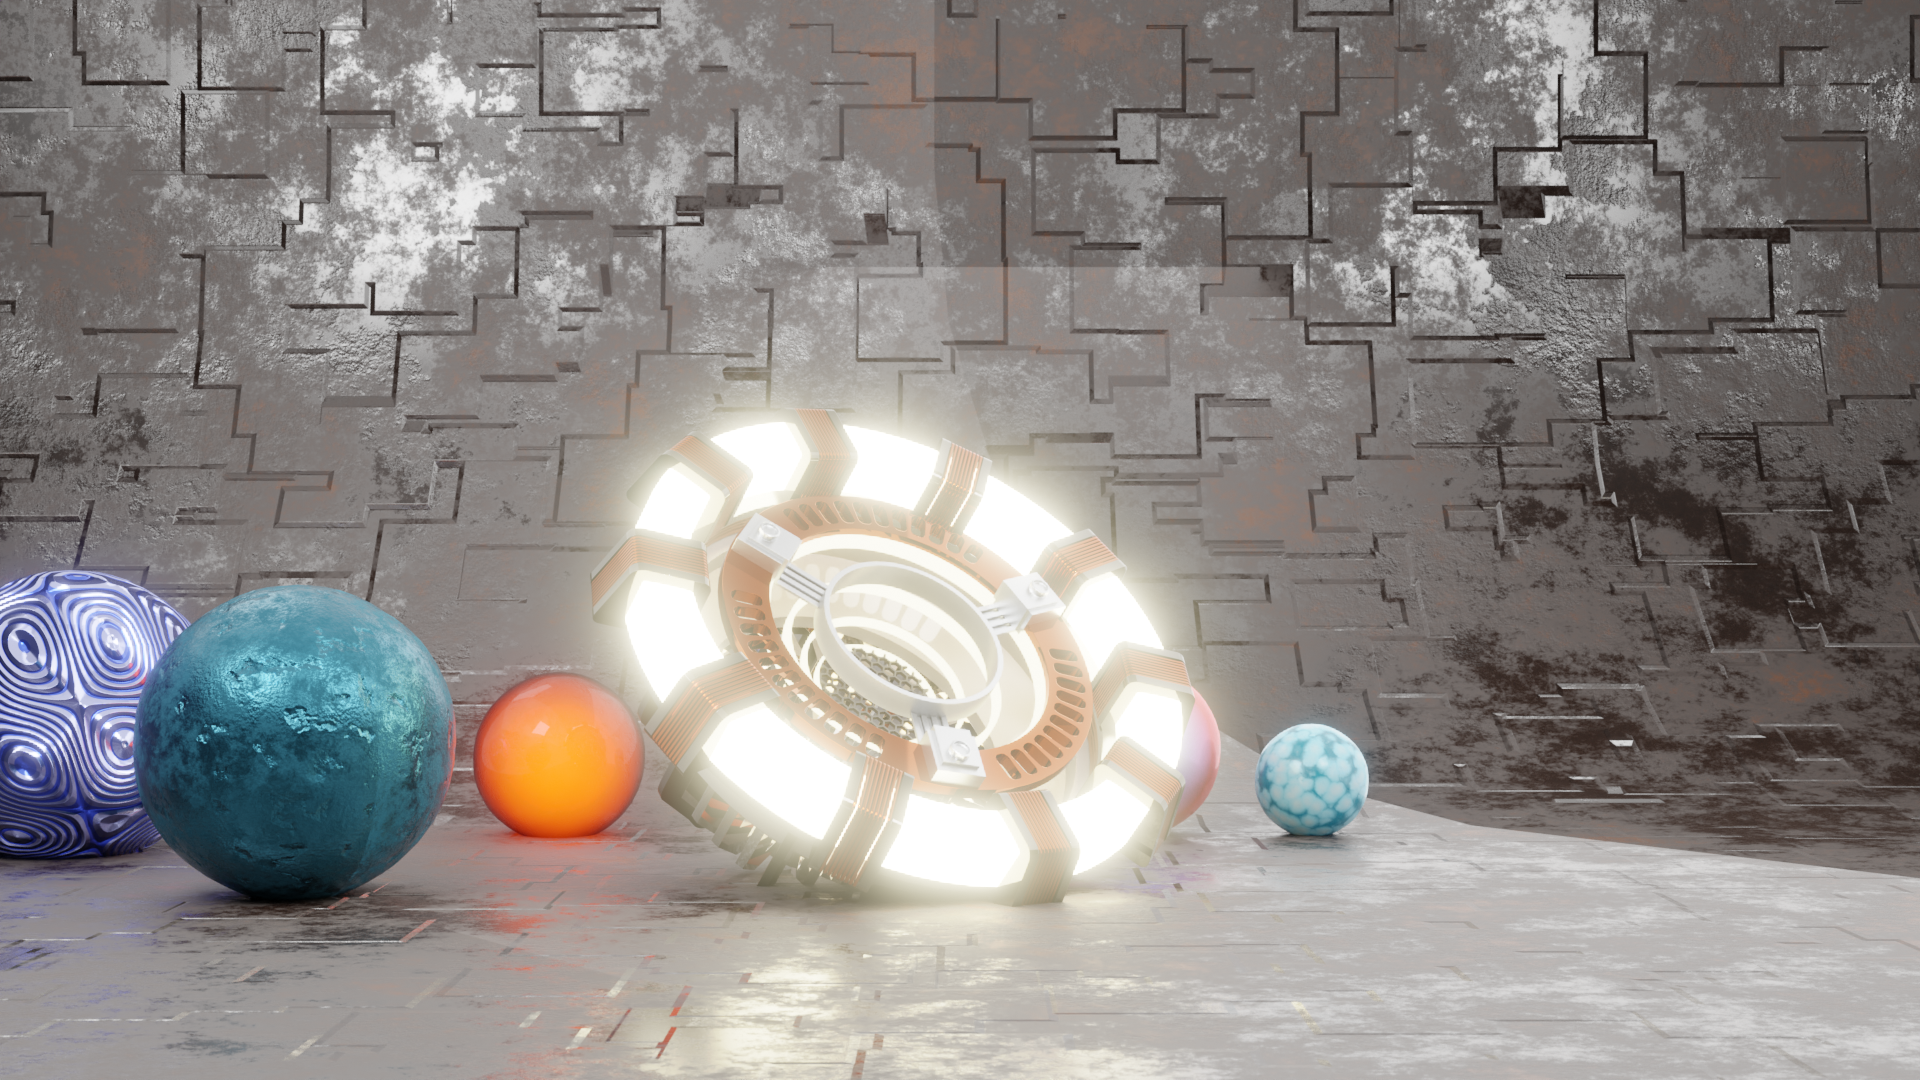

In [ ]:
import os
import io
import subprocess
import time
import ipywidgets as widgets
from tqdm.notebook import tqdm
from IPython.display import display, Image, clear_output
from google.colab import drive, files

# Mount Google Drive to access the desired location
drive.mount('/content/drive')

# Function to handle file upload and move the file
def handle_file_upload(change):
    print("Upload Started")
    uploaded_file = list(upload_button.value.keys())[0]
    total_size = len(upload_button.value[uploaded_file]['content'])

    target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    with tqdm(total=total_size, unit='B', unit_scale=True, desc=uploaded_file) as pbar:
        with io.BytesIO(upload_button.value[uploaded_file]['content']) as f:
            with open(os.path.join(target_path, uploaded_file), 'wb') as destination_file:
                while True:
                    buf = f.read(8192)
                    if not buf:
                        break
                    destination_file.write(buf)
                    pbar.update(len(buf))

    print(f"File uploaded and moved to {target_path + uploaded_file}")
    refresh_dropdown()

def refresh_dropdown():
    target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
    blend_files = [f for f in os.listdir(target_path) if f.endswith('.blend')]
    blend_files_dropdown.options = blend_files

def execute_code():
    folder_path = "/content"
    file_path = f"{folder_path}/sampleChanger.py"
    blend_file_name = blend_files_dropdown.value
    num_samples = num_samples_input.value
    res_x = res_x_input.value
    res_y = res_y_input.value

    with open(file_path, 'w') as file:
        file.write(code.format(num_samples=num_samples, res_x=res_x, res_y=res_y, blend_file_name=blend_file_name))

    print(f"Code written to {file_path}")
    print("Executing the code...")
    !python {file_path}
    print("Code executed successfully!")

def run_with_subprocess():
    print("Starting Sub Process")
    # Set the path to the Blender executable
    blender_executable = "./blender-3.5.1-linux-x64/blender"  # Replace with the actual Blender executable path

    # Set the path to the modify_samples.py script
    modify_samples_script_path = "/content/sampleChanger.py"  # Replace with the actual script path

    # Execute the script using Blender's CLI
    subprocess.run([blender_executable, "--background", "--python", modify_samples_script_path])
    print("Sub Process Completed")

def render_blend_file(_):
    execute_code()
    run_with_subprocess()
    print("Starting Render")
    file_path = os.path.join(target_path, blend_files_dropdown.value)
    !./blender-3.5.1-linux-x64/blender -b "{file_path}" -noaudio -E 'CYCLES' -o "/content/drive/MyDrive/Blender/Renders/CyclesTestRender_##.png" -f 1 -- --cycles-device CUDA
    print("Render Completed Waiting for render to be available")
    time.sleep(2)
    rendered_image_path = "/content/drive/MyDrive/Blender/Renders/CyclesTestRender_01.png"
    with open(rendered_image_path, 'rb') as f:
        image = f.read()
    display(Image(image))

def extract_blender_archive(_):
    print("Starting Installation")
    !cp /content/drive/MyDrive/Blender/blender-3.5.1-linux-x64.tar.xz /content/blender-3.5.1-linux-x64.tar.xz
    !tar xf /content/blender-3.5.1-linux-x64.tar.xz
    print("Blender Installation Completed")

def runot_prerequirements(_):
    !wget https://download.blender.org/release/Blender3.5/blender-3.5.1-linux-x64.tar.xz

def run_prerequirements(_):
    !cp /content/blender-3.5.1-linux-x64.tar.xz  /content/drive/MyDrive/Blender/blender-3.5.1-linux-x64.tar.xz
    !pip install google-colab
    !pip install ipywidgets
    !pip install tqdm
    !pip install pillow
    clear_output
    print("Pre Requirements Completed")
    display(main_ui)

# Create the GUI elements
upload_button = widgets.FileUpload(description="Upload .blend file")
upload_button.observe(handle_file_upload, names='value')
refreshfiles_button = widgets.Button(description="Refresh Files")
refreshfiles_button.on_click(refresh_dropdown)

target_path = '/content/drive/MyDrive/Blender/BlendFiles/'
if not os.path.exists(target_path):
    os.makedirs(target_path)
    print(f"Folder created: {target_path}")
else:
    print(f"Folder already exists: {target_path}")
blend_files = [f for f in os.listdir(target_path) if f.endswith('.blend')]
blend_files_dropdown = widgets.Dropdown(options=blend_files, description="Select .blend file:")
num_samples_input = widgets.IntText(description="Samples:", value=123)
res_x_input = widgets.IntText(description="Width:", value=1920)
res_y_input = widgets.IntText(description="Height:", value=1080)

code = '''
import bpy

# Set the path to the .blend file
blend_file_path = "/content/drive/MyDrive/Blender/BlendFiles/" + "{blend_file_name}"

# Set the number of samples for rendering
num_samples = {num_samples}

# Set the resolution
res_x = {res_x}
res_y = {res_y}

# Open the .blend file
bpy.ops.wm.open_mainfile(filepath=blend_file_path)

# Set the render samples
bpy.context.scene.cycles.samples = num_samples

# Set the output resolution
bpy.context.scene.render.resolution_x = res_x
bpy.context.scene.render.resolution_y = res_y

# Save the changes back to the .blend file
bpy.ops.wm.save_as_mainfile(filepath=blend_file_path)
'''

# Create the buttons
extract_blender_button = widgets.Button(description="Install Blender")
extract_blender_button.on_click(extract_blender_archive)

render_button = widgets.Button(description="Render")
render_button.on_click(render_blend_file)

prerequirements_button = widgets.Button(description="Run Prerequirements")
prerequirements_button.on_click(run_prerequirements)

prerequirementsot_button = widgets.Button(description="Run One Time Prerequirements")
prerequirementsot_button.on_click(runot_prerequirements)

# Dropdown for selecting rendering device
cuda_cpu_dropdown = widgets.Dropdown(
    options=['CUDA', 'CPU'],
    value='CUDA',
    description='Select rendering device:'
)

# Add styles to the buttons
def set_widget_styles(widget, color):
    widget.layout.border = '2px solid #4CAF50'  # Add a border to create rounded corners
    widget.layout.padding = '1px 5px 5px 5px'  # Add padding to increase button size
    widget.style.button_color = color  # Set the button color (you can change this to any color)

set_widget_styles(upload_button,'#4CAF50')
set_widget_styles(refreshfiles_button,'#4CAF50')
set_widget_styles(render_button,'#FF4D4D')
set_widget_styles(prerequirements_button,'#4CAF50')
set_widget_styles(prerequirementsot_button,'#4CAF50')
set_widget_styles(extract_blender_button,'#4DA6FF')

# Create the UI layout
inputs_section = widgets.VBox([
    widgets.Label("Render Settings:"),
    upload_button,
    refreshfiles_button,
    blend_files_dropdown,
    num_samples_input,
    res_x_input,
    res_y_input
])

execute_section = widgets.HBox([render_button])

prerequirements_section = widgets.HBox([prerequirementsot_button, widgets.Label(" "), prerequirements_button, widgets.Label(" "), extract_blender_button])

main_ui = widgets.VBox([inputs_section, prerequirements_section, execute_section])

# Display the UI
display(main_ui)

# File upload widget
upload_widget = files.upload()

# Handle file upload
if upload_widget:
    for file_name, file_content in upload_widget.items():
        save_dir = "/content/drive/MyDrive/Blender/BlendFiles/"
        save_path = os.path.join(save_dir, file_name)

        with open(save_path, 'wb') as f:
            f.write(file_content)

        print(f"File saved to: {save_path}")
        refresh_dropdown()


In [ ]:
!wget "https://kd96.softsaaz.ir/Plugin/Blender.Market.Kit.Ops.2.Pro.v2.22.8.Hardpoints.Edition.rar"

--2023-07-21 06:50:14--  https://kd96.softsaaz.ir/Plugin/Blender.Market.Kit.Ops.2.Pro.v2.22.8.Hardpoints.Edition.rar
Resolving kd96.softsaaz.ir (kd96.softsaaz.ir)... 212.33.193.66
Connecting to kd96.softsaaz.ir (kd96.softsaaz.ir)|212.33.193.66|:443... ^C
